In [1]:
import torch
import numpy as np
from pandas import factorize, DataFrame
from copy import deepcopy
from matplotlib import pyplot as plt

from uncertain.models.ExplicitFactorizationModel import ExplicitFactorizationModel
from uncertain.models.UncertainWrapper import UncertainWrapper, LinearUncertaintyEstimator
from uncertain.models.multimodelling import EnsembleRecommender, ResampleRecommender
from uncertain.cross_validation import random_train_test_split as split
from uncertain.interactions import Interactions
from uncertain.models.CPMF import CPMF
from uncertain.models.OrdRec import OrdRec

from utils import dataset_loader
from evaluation import evaluate

MF_params = {'embedding_dim': 50, 'n_iter': 100, 'l2': 4e-6, 'learning_rate': 0.01,
             'batch_size': int(1e6), 'use_cuda': True}
CPMF_params = {'embedding_dim': 50, 'n_iter': 100, 'sigma': 1e5, 'learning_rate': 0.01,
               'batch_size': int(1e6), 'use_cuda': True}
OrdRec_params = {'embedding_dim': 10, 'n_iter': 70, 'l2': 2e-7, 'learning_rate': 0.01,
                 'batch_size': int(1e6), 'use_cuda': True}


In [2]:
import pickle
with open('results10M.pkl', 'rb') as f:
    results = pickle.load(f)

In [3]:
keys = ['Baseline', 'Ensemble', 'CPMF', 'OrdRec']
RMSE = [[results[key][i]['RMSE'].item() for i in range(4)] for key in keys]
RMSE = DataFrame(RMSE, index=keys, columns=['Fold '+str(i+1) for i in range(4)])
RMSE['Average'] = RMSE.mean(1)
RMSE['Std error'] = RMSE.std(1) / np.sqrt(4)
RMSE

,Fold 1,Fold 2,Fold 3,Fold 4,Average,Std error
Baseline,0.798613,0.800074,0.798386,0.799073,0.799036,0.000324
Ensemble,0.784748,0.785950,0.784628,0.785658,0.785246,0.000284
CPMF,0.833248,0.832574,0.832493,0.833186,0.832875,0.000172
OrdRec,0.995350,0.998508,0.996581,1.000113,0.997638,0.000910


In [4]:
precision = [[results[key][i]['Precision'].cpu().numpy() for i in range(4)] for key in keys]
precision = DataFrame(np.array(precision).mean(1), index=keys, columns=['Top '+str(i+1) for i in range(10)])
precision

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
Baseline,0.141984,0.126059,0.115742,0.108548,0.102426,0.097546,0.093528,0.089932,0.086824,0.084007
Ensemble,0.158188,0.139896,0.127605,0.118914,0.111902,0.106233,0.101271,0.097038,0.093465,0.090246
CPMF,0.133741,0.120811,0.111920,0.105247,0.100244,0.095969,0.092049,0.088802,0.085886,0.083306
OrdRec,0.096713,0.082708,0.074386,0.068930,0.064960,0.061809,0.059286,0.057195,0.055333,0.053731


In [5]:
recall = [[results[key][i]['Recall'].cpu().numpy() for i in range(4)] for key in keys]
recall = DataFrame(np.array(recall).mean(1), index=keys, columns=['Top '+str(i+1) for i in range(10)])
recall

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
Baseline,0.015224,0.027167,0.037517,0.046915,0.055247,0.063015,0.070399,0.077172,0.083763,0.090018
Ensemble,0.016684,0.029679,0.040671,0.050575,0.059586,0.067884,0.075472,0.082578,0.089444,0.095787
CPMF,0.014357,0.026203,0.036650,0.046168,0.055166,0.063578,0.071192,0.078640,0.085513,0.092320
OrdRec,0.008697,0.014789,0.019647,0.023818,0.027682,0.031283,0.034760,0.038120,0.041435,0.044702


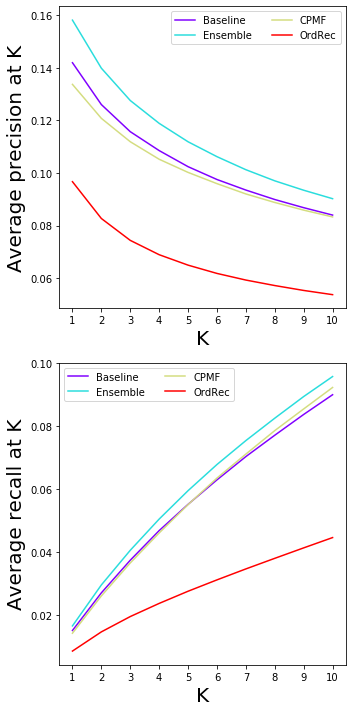

In [6]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 4)))
f, ax = plt.subplots(nrows=2, figsize=(5, 10))
for key in keys:
    c = next(color)
    ax[0].plot(np.arange(1, 11), precision.loc[key], '-', color=c, label=key)
    ax[1].plot(np.arange(1, 11), recall.loc[key], '-', color=c, label=key)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', Fontsize=20)
ax[0].set_ylabel('Average precision at K', Fontsize=20)
ax[0].legend(ncol=2)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xticklabels(np.arange(1, 11))
ax[1].set_xlabel('K', Fontsize=20)
ax[1].set_ylabel('Average recall at K', Fontsize=20)
ax[1].legend(ncol=2)
f.tight_layout()

In [7]:
keys = list(results.keys())[1:]
RPI = np.array([[results[key][i]['RPI'].item() for i in range(4)] for key in keys])
Pearson = np.array([[results[key][i]['Correlation'][0].item() for i in range(4)] for key in keys])
Spearman = np.array([[results[key][i]['Correlation'][1].item() for i in range(4)] for key in keys])
out = DataFrame([RPI.mean(1),
                 RPI.std(1) / np.sqrt(4),
                 Pearson.mean(1),
                 Pearson.std(1) / np.sqrt(4),
                 Spearman.mean(1),
                 Spearman.std(1) / np.sqrt(4)],
                index=['Average RPI', 'RPI SE', 'Average Pearson correlation', 'Pearson correlation SE', 
                       'Average Spearman correlation', 'Spearman correlation SE'], columns=keys)
out.T

,Average RPI,RPI SE,Average Pearson correlation,Pearson correlation SE,Average Spearman correlation,Spearman correlation SE
User support,0.193040,0.000831,0.048525,0.000213,0.067609,0.000402
Item support,0.114283,0.002783,0.034971,0.000491,0.043268,0.000509
Item variance,0.464546,0.001296,0.124583,0.000301,0.105098,0.000354
FCV,0.930542,0.001969,0.243973,0.000776,0.237836,0.000463
BCV,1.055320,0.001490,0.289123,0.000776,0.257957,0.000465
CPMF,0.865390,0.004492,0.225690,0.000900,0.195588,0.001056
OrdRec,0.207535,0.013197,0.135667,0.001808,0.244534,0.000971
Ensemble,0.433130,0.005399,0.101909,0.001075,0.078264,0.000802
Resample,0.618926,0.002641,0.147926,0.000659,0.119736,0.000603


In [8]:
rmse = [[results[key][i]['Quantile RMSE'].cpu().numpy() for i in range(4)] for key in keys]
rmse = DataFrame(np.array(rmse).mean(1), index=keys, columns=['Bin '+str(i+1) for i in range(20)])
rmse

,Bin 1,Bin 2,Bin 3,Bin 4,Bin 5,Bin 6,Bin 7,Bin 8,Bin 9,Bin 10,Bin 11,Bin 12,Bin 13,Bin 14,Bin 15,Bin 16,Bin 17,Bin 18,Bin 19,Bin 20
User support,0.757281,0.759642,0.743681,0.758667,0.761804,0.758314,0.780936,0.767298,0.775425,0.781619,0.793102,0.789308,0.799805,0.811573,0.806813,0.820632,0.831709,0.851341,0.873196,0.929643
Item support,0.762125,0.751935,0.784518,0.790540,0.763630,0.795211,0.801426,0.791025,0.785180,0.789843,0.791160,0.783881,0.796555,0.777676,0.789354,0.795867,0.801805,0.816309,0.825011,0.963693
Item variance,0.688828,0.687917,0.705916,0.728098,0.738779,0.747987,0.769605,0.767189,0.774483,0.778203,0.788882,0.793348,0.805314,0.820777,0.828936,0.837430,0.864338,0.887031,0.898552,0.997258
FCV,0.608066,0.566485,0.590694,0.613564,0.642018,0.663144,0.688102,0.709236,0.729849,0.752922,0.776561,0.800345,0.825605,0.849079,0.875484,0.905593,0.942232,0.986388,1.036254,1.121483
BCV,0.504843,0.546113,0.585325,0.613189,0.637718,0.662195,0.686623,0.708690,0.729531,0.747338,0.770022,0.791841,0.818389,0.844124,0.870053,0.901006,0.939973,0.984351,1.052328,1.206992
CPMF,0.725432,0.696463,0.686120,0.684114,0.687057,0.695328,0.710597,0.723432,0.738218,0.752311,0.773198,0.796588,0.819606,0.842809,0.871020,0.907805,0.951214,1.008340,1.081924,1.240636
OrdRec,1.059120,0.993228,0.964153,0.963355,0.954468,0.948193,0.941267,0.918321,0.935247,0.955477,0.969845,0.975244,0.981009,0.972200,0.965780,0.988078,1.056671,1.072984,1.102724,1.191504
Ensemble,0.833745,0.730428,0.715687,0.714963,0.715936,0.718725,0.726277,0.733461,0.741281,0.750834,0.759370,0.767876,0.775595,0.787948,0.802345,0.814808,0.833205,0.856296,0.890107,0.977725
Resample,0.699182,0.709875,0.712363,0.718526,0.726792,0.730181,0.735994,0.743353,0.751663,0.762255,0.773210,0.782923,0.798917,0.809558,0.826104,0.845369,0.864909,0.896298,0.940490,1.054976


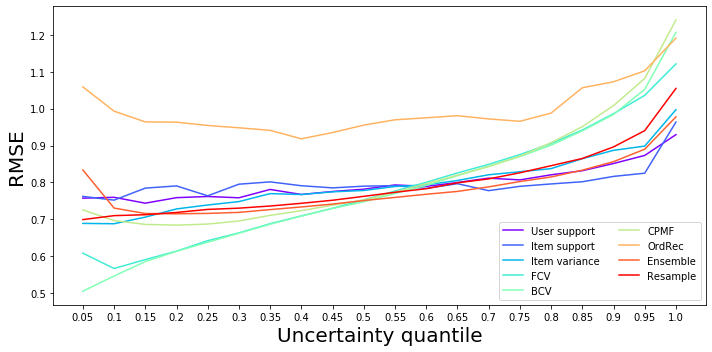

In [9]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(1, 21), rmse.loc[key], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('RMSE', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

In [10]:
MAP = [[results[key][i]['Quantile MAP'].cpu().numpy() for i in range(4)] for key in keys if 'Item' not in key]
MAP = DataFrame(np.array(MAP).mean(1), index=[k for k in keys if 'Item' not in k], columns=['Bin '+str(i+1) for i in range(20)])
MAP

,Bin 1,Bin 2,Bin 3,Bin 4,Bin 5,Bin 6,Bin 7,Bin 8,Bin 9,Bin 10,Bin 11,Bin 12,Bin 13,Bin 14,Bin 15,Bin 16,Bin 17,Bin 18,Bin 19,Bin 20
User support,0.269754,0.170890,0.139894,0.120401,0.106148,0.096006,0.089711,0.081278,0.076241,0.067536,0.063663,0.058787,0.056551,0.052838,0.048964,0.044502,0.040553,0.035926,0.031992,0.033215
FCV,0.153564,0.122255,0.106151,0.099307,0.093012,0.089181,0.083138,0.082599,0.081320,0.079497,0.077436,0.075012,0.073306,0.072610,0.068932,0.069933,0.067715,0.064258,0.063036,0.057903
BCV,0.155228,0.126523,0.112741,0.102722,0.097871,0.091391,0.088750,0.086443,0.082816,0.079042,0.076270,0.074752,0.071234,0.070345,0.069136,0.065935,0.061455,0.060851,0.056275,0.050332
CPMF,0.122748,0.137337,0.129808,0.116869,0.108500,0.099402,0.090004,0.083283,0.075666,0.068793,0.064165,0.061048,0.059828,0.057432,0.055702,0.055735,0.057711,0.061465,0.067554,0.093089
OrdRec,0.119048,0.116628,0.083020,0.065442,0.058602,0.053951,0.049665,0.049463,0.049486,0.051339,0.051769,0.049585,0.044739,0.041189,0.037453,0.033270,0.032000,0.031845,0.030921,0.025199
Ensemble,0.033742,0.042000,0.052944,0.057563,0.063600,0.071039,0.074266,0.079065,0.084128,0.090557,0.092806,0.093935,0.099911,0.103991,0.108582,0.110953,0.118394,0.126001,0.138694,0.162747
Resample,0.047713,0.059124,0.064415,0.068224,0.072676,0.075404,0.080082,0.079957,0.081614,0.084941,0.086058,0.087762,0.089771,0.091836,0.095155,0.096053,0.099321,0.103919,0.106823,0.109319


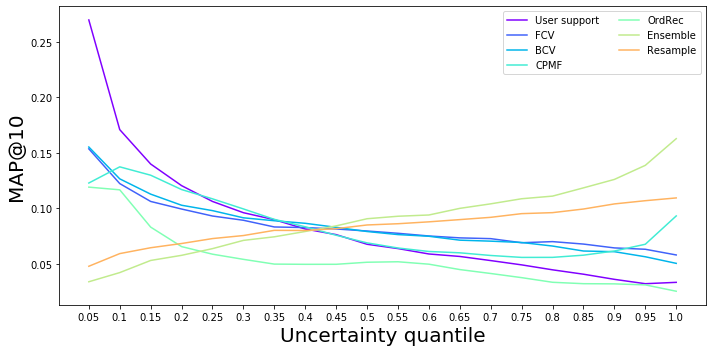

In [11]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in [key for key in keys if 'Item' not in key]:
    c = next(color)
    ax.plot(np.arange(1, 21), MAP.loc[key], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('MAP@10', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

In [12]:
RRI = [[results[key][i]['RRI'].cpu().numpy() for i in range(4)] for key in keys if 'User' not in key]
RRI = DataFrame(np.array(RRI).mean(1), index=[key for key in keys if 'User' not in key], columns=['Top '+str(i+2) for i in range(9)])
RRI

,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
Item support,0.194831,0.292279,0.351098,0.389159,0.417482,0.440458,0.459103,0.476078,0.490386
Item variance,-0.001125,-0.000425,0.003573,0.005492,0.003008,0.002930,0.001864,0.000366,-0.001320
FCV,0.029443,0.043634,0.047055,0.054113,0.056289,0.059842,0.060743,0.061160,0.061172
BCV,0.008733,0.003236,-0.000089,0.001516,-0.001026,-0.001993,-0.003846,-0.005813,-0.008160
CPMF,-0.092338,-0.124829,-0.133393,-0.140696,-0.143365,-0.144472,-0.143532,-0.141660,-0.140687
OrdRec,0.064365,0.097976,0.110946,0.122671,0.125664,0.127004,0.125245,0.123765,0.121101
Ensemble,0.019851,0.041406,0.063343,0.075906,0.082712,0.086432,0.088779,0.090150,0.090142
Resample,0.051269,0.086191,0.110918,0.124149,0.132748,0.135332,0.136623,0.136230,0.136190


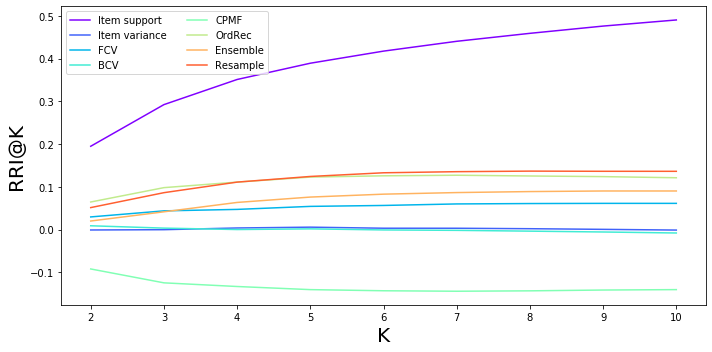

In [13]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in [key for key in keys if 'User' not in key]:
    c = next(color)
    ax.plot(np.arange(2, 11), RRI.loc[key], '-', color=c, label=key)
ax.set_xlabel('K', Fontsize=20)
ax.set_ylabel('RRI@K', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

In [14]:
Likelihood = np.array([[results[key][i]['Classification'][0].item() for i in range(4)] for key in keys])
AUC = np.array([[results[key][i]['Correlation'][1].item() for i in range(4)] for key in keys])
out = DataFrame([Likelihood.mean(1), AUC.mean(1)], index=['log-Likelihood', 'AUC'], columns=keys)
out.T

,log-Likelihood,AUC
User support,-0.486809,0.067609
Item support,-0.487135,0.043268
Item variance,-0.481886,0.105098
FCV,-0.467266,0.237836
BCV,-0.458319,0.257957
CPMF,-0.491256,0.195588
OrdRec,-0.526102,0.244534
Ensemble,-0.474198,0.078264
Resample,-0.480805,0.119736
